# Cart Pole (Simple DeepQ Learning + Replay Memory) 

In this notebook, we will solve the cart pole task using DeepQ Learning and a replay memory

In [1]:
import gym
import numpy as np
import random
import imageio 
import math
from matplotlib import pyplot as plt

## Context

In [2]:
env = gym.make('CartPole-v1')

The Cart Pole task aims to balance a pole that is attached to a cart which moves along an axis (left or right).

Here we can take 2 actions encoded as 'int' (0 or 1) : move left or move right.

In [3]:
env.action_space

Discrete(2)

The observation state is a vector of 4 numbers : cart position, cart velocity, pole angle and pole angular velocity. Some of these nubers are bounded, other are not.

What's important is that the state is not discrete, so there is an infinite combination of state, making a QTable for such a problem is possible but not the right solution because of the infinite amount of state.

In [4]:
env.observation_space.shape

(4,)

If a QTable is not the right solution, the only remaining is using DeepQ Learning.

Instead of creating a table that will store all the Qvalues, we use a neural network to approximatethose QValues. The neural network allow us to have an infinite number of states, it will only depends on the network's weights and not a static table.

## DeepQ Learning (With replay memory)

The difference between a simple DeepQ Learning alogorithm and another one using replay memory is that the first one will only learn from its last experience, unlike the other one that can learn from past experience. 

This simple make a huge difference, because without memory the model can't generalize well, and is very likely to not train on every possible situations.

### Replay Memory (deque)
First create the replay memory, that will store : the current state, the action taken, the reward, the next state, and if the state is terminal.

Basically, the memory doesn't have an infinite capcity (performance wise), so we setup the memory as a deque, it will automatically handle incoming experience, and throwing the older ones.


The methods created are :
- 'push' : it append a new experience to the memory
- 'sample' : it will randomly take some experience (a batch) in the memory and output them, those will be used to update the network weights.
- '__len__' : it overrides the 'len' methods to return the memory length, used to start updating network's weights when there are enough experience stored.

In [5]:
from collections import deque
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

### The network

The network can be set how you want, but because here is a quite simple case with not a huge amount of state, it doesn't need to be a very deep network, 3 simple dense layer with 32 units are sufficient.


The input_shape or input, is what is received, the observation so a vector 4 values (Shape : (4,)).

The output are the QValues for the possible actions, here the QValues for going left or right. Because its numbers, the activation is linear, and the losss is MSE.

In [6]:
from keras import layers, Sequential, optimizers
def create_model(input_shape, output_shape, learning_rate):
    model = Sequential()
    model.add(layers.Dense(64, input_shape=(input_shape,), activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(output_shape, activation='linear'))
    return model

### DeepQ Learning algorithm

The algorithm is pretty much the same as the QLearning one, the difference will be in the part of the QValue estimation.
Before, we would take the QTable, update the corresponding state with the action taken, here the updates are only made the networks learns from memory.

By taking a batch of past experiences we can compute the corresponding QValue, but instead of storing it in a table, we update the network's weights but training the model to associate the qvalues to a state in order to take the best action.

Something else can change, the epsilon decay.
If in the other cases we simply decrease epsilon at each episode to make training less random, here we can apply a small modification. Instead of decreasing epsilon at each episode, the more an episode is long (the better it is as it is the goal), the more we decrease the epsilon as good choices were made, the decreasing rate will be way smaller of course, but it will be made at each time sep instead of at each episode. The decreasing is proportionnal to the agent score, if it has a high score, the decreasing will be such.

In [11]:
rewards_list = []

def DeepQLearning(env, learning_rate, discount, epsilon, max_steps, episodes, batch_size_p=32):
    
    input_shape = env.observation_space.shape[0]
    output_shape = env.action_space.n

    model = create_model(
        input_shape=input_shape, 
        output_shape=output_shape, 
        learning_rate=learning_rate)

    model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate = learning_rate))


    memory = ReplayMemory(capacity=100000)
    batch_size = batch_size_p
    

    for i in range(episodes):
        state, info = env.reset()
        state = state.reshape(1, input_shape)
        done = False
        reward_tot = 0

        if i > 50:
            #model.save_weights(f"model.weights-eps{i}.h5")
            model.save_weights("model.weights.h5", overwrite=True)

        
        for j in range (max_steps):   



            if np.random.rand() <= epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(model.predict(state, verbose=0)[0])


            new_state, reward, done, truncated, info = env.step(action)
            new_state = new_state.reshape(1, input_shape) 
            reward_tot += reward

            memory.push(state, action, reward, new_state, done)
            state = new_state

            
            # Only update the model if there are enough experiences in memory
            if len(memory) >= batch_size:
                
                states, actions, rewards, new_states, dones = zip(*memory.sample(batch_size))

                
                dones = np.array(dones, dtype=np.bool_)
                #states = np.array(states)
                states = np.squeeze(states)
                ####
                actions = np.array(actions)
                ####
                
                #new_states = np.array(new_states)
                new_states = np.squeeze(new_states)
                
                targets = model.predict_on_batch(states)

                #q_values_next = target_model.predict_on_batch(new_states)
                q_values_next = model.predict_on_batch(new_states)


                max_q_values_next = np.amax(q_values_next, axis=1)
                
                targets[range(batch_size), actions] = rewards + discount * max_q_values_next *  (1 - dones) 

                model.fit(states, targets, epochs=1, verbose=0)

                model.save_weights('model.weights.h5', overwrite=True)
                
                if i>10 and epsilon > 0.01:
                    epsilon *= 0.9995

            if done:
                rewards_list.append(reward_tot)
                print("Episodes n°:", i, "Epsilon:", epsilon, "Total reward:", j)
                break




## Training time !

In [12]:
DeepQLearning(env, 
          learning_rate=0.01, 
          discount=0.99, 
          epsilon=1.0, 
          max_steps=10000, 
          episodes=1000,
          batch_size_p=128)

Episodes n°: 0 Epsilon: 1.0 Total reward: 27
Episodes n°: 1 Epsilon: 1.0 Total reward: 57
Episodes n°: 2 Epsilon: 1.0 Total reward: 18
Episodes n°: 3 Epsilon: 1.0 Total reward: 18
Episodes n°: 4 Epsilon: 1.0 Total reward: 28
Episodes n°: 5 Epsilon: 1.0 Total reward: 24
Episodes n°: 6 Epsilon: 1.0 Total reward: 14
Episodes n°: 7 Epsilon: 1.0 Total reward: 41
Episodes n°: 8 Epsilon: 1.0 Total reward: 46
Episodes n°: 9 Epsilon: 1.0 Total reward: 13
Episodes n°: 10 Epsilon: 1.0 Total reward: 55
Episodes n°: 11 Epsilon: 0.9816655328642288 Total reward: 36
Episodes n°: 12 Epsilon: 0.9617413289958378 Total reward: 40
Episodes n°: 13 Epsilon: 0.9550309756089804 Total reward: 13
Episodes n°: 14 Epsilon: 0.9393983797045142 Total reward: 32
Episodes n°: 15 Epsilon: 0.9319113089671119 Total reward: 15
Episodes n°: 16 Epsilon: 0.9184927597143733 Total reward: 28
Episodes n°: 17 Epsilon: 0.8949139064422772 Total reward: 51
Episodes n°: 18 Epsilon: 0.8754359736720191 Total reward: 43
Episodes n°: 19 

KeyboardInterrupt: 

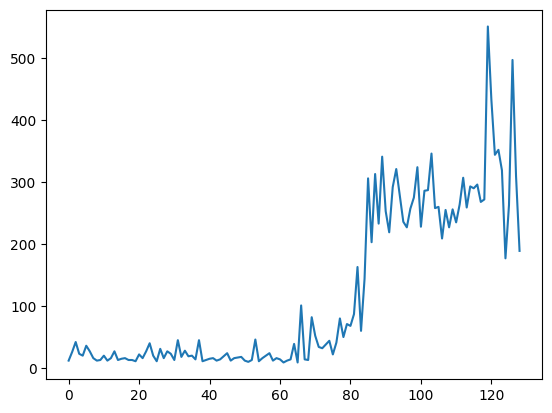

In [27]:
plt.plot(rewards_list)

The graph is very representative of the DeepQ Learning method in general, there is a period where the score is pretty much low because most of the actions are random (epsilon os high), when a threshold is passed the progression is way much better because the network took the part in the learning process (low epsilon).

## Create the GIF

In [28]:
images = []
env = gym.make('CartPole-v1', render_mode = 'rgb_array')
state,info = env.reset()


input_shape = env.observation_space.shape[0]
output_shape = env.action_space.n

state = state.reshape(1, input_shape)


model = create_model(
        input_shape=input_shape, 
        output_shape=output_shape, 
        learning_rate=0.001
)
model.load_weights('model.weights.h5')
model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate = 0.001))

score = 0
done = False
while not done:

        action = np.argmax(model.predict(state, verbose=0))
        new_state, reward, done, trunc, info = env.step(action)
        state = new_state.reshape(1, input_shape) 

        frame = env.render()  # Save the frame
        images.append(frame)


        if done == True:
                break
        score +=1

env.close()
imageio.mimsave('img/CartPoleSimpleDQN1.gif', images, fps=59)

c:\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
